In [1]:
# 以下が必要
# conda install pandas-profiling
# conda install category_encoders -y
# conda install graphviz -y
# conda install python-graphviz -y
# conda install -c saravji boruta -y
# conda install -c tqdm -y

In [2]:
%ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は CA67-50C9 です

 C:\Users\tsk_sato\Documents\DataAnalysisProjects のディレクトリ

2019/03/27  17:41    <DIR>          .
2019/03/27  17:41    <DIR>          ..
2018/08/30  15:52                20 .gitignore
2019/03/27  16:52    <DIR>          .ipynb_checkpoints
2018/08/24  13:25             2,141 anomaly_detection_method_evaluation.py
2019/03/27  14:59             4,398 CV_Kperiod.ipynb
2019/03/25  17:56    <DIR>          data
2019/03/18  17:40             2,607 EDA_GMS.ipynb
2019/03/18  17:49            23,945 folium_uktaxi.ipynb
2018/08/23  15:12             5,577 GMM_SkillCraft1.ipynb
2018/08/23  15:13             5,697 KDE_SkillCraft1.ipynb
2019/03/18  17:49            13,765 keras_001.ipynb
2018/08/30  15:49             9,149 LOF_SkillCraft1.ipynb
2019/03/19  16:35            31,153 MTS_SkillCraft1.ipynb
2019/03/18  17:49    <DIR>          output
2018/09/03  11:16                66 README.md
2019/03/20  14:37           662,942 Template.ipynb
201

In [3]:
import datetime
import graphviz
import itertools
import os
import platform
import socket
import sys
import time
import warnings
import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 300)

In [4]:
print("="*80)
print("DATE: {}".format(datetime.datetime.now()))
print("PID: {}".format(os.getpid()))
print("FILE: {}".format(os.path.basename(os.path.abspath('__file__'))))
print("HOST: {}".format(platform.node()))
print("ENV: {}".format(platform.platform()))
print("="*80)

DATE: 2019-03-27 17:59:27.958366
PID: 15632
FILE: __file__
HOST: Y-project-11
ENV: Windows-10-10.0.17134-SP0


In [5]:
for _ in tqdm(range(100)):
    time.sleep(0.1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.44it/s]


# データ読み込み

In [6]:
dtypes = {
    "Administrative"            : "float16",
    "Administrative_Duration"   : "float16",
    "Informational"             : "int8",
    "Informational_Duration"    : "float16",
    "ProductRelated"            : "int8",
    "ProductRelated_Duration"   : "float16",
    "BounceRates"               : "float16",
    "ExitRates"                 : "float16",
    "PageValues"                : "float16",
    "SpecialDay"                : "float16",
    "Month"                     : "category",
    "OperatingSystems"          : "int8",
    "Browser"                   : "int8",
    "Region"                    : "int8",
    "TrafficType"               : "int8",
    "VisitorType"               : "category",
    "Weekend"                   : "category",
    "Revenue"                   : "category"
}

In [7]:
%time
file_name = "data/online_shoppers_intention.csv"
df = pd.read_csv(file_name, header=0, index_col=None, sep=',', dtype=dtypes, low_memory=True)

Wall time: 0 ns


In [8]:
df.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0,0.0,1,0.0,0.199951,0.199951,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
1,0.0,0.0,0,0.0,2,64.0,0.000000,0.099976,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
2,0.0,0.0,0,0.0,1,0.0,0.199951,0.199951,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE


In [9]:
df.dtypes

Administrative              float16
Administrative_Duration     float16
Informational                  int8
Informational_Duration      float16
ProductRelated                 int8
ProductRelated_Duration     float16
BounceRates                 float16
ExitRates                   float16
PageValues                  float16
SpecialDay                  float16
Month                      category
OperatingSystems               int8
Browser                        int8
Region                         int8
TrafficType                    int8
VisitorType                category
Weekend                    category
Revenue                    category
dtype: object

In [10]:
# レポート作成
# bool型はカテゴリカルにしないとレポート作成できないらしい
# https://github.com/pandas-profiling/pandas-profiling/issues/49
le = LabelEncoder()
cat_cols  = [k for k, v in dtypes.items() if v=="category"]
for lab in cat_cols:
    le.fit(df[lab])
    df[lab] = le.transform(df[lab])
pdp.ProfileReport(df)

Number of variables,18
Number of observations,12330
Total Missing (%),0.0%
Total size in memory,457.6 KiB
Average record size in memory,38.0 B
Numeric,17
Categorical,0
Date,0
Text (Unique),0
Rejected,1
Distinct count,27


In [11]:
# 行数列数
df.shape

(12330, 18)

In [12]:
# 基本統計量
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,1.233000e+04,12330.000000,1.233000e+04,12330.000000,1.233000e+04,12330.000000,12330.000000,1.233000e+04,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.314453,inf,0.503569,inf,21.827818,inf,0.022186,0.043060,inf,0.061432,5.163990,2.124006,2.357097,3.147364,4.069586,1.718329,0.232603,0.154745
std,3.322266,inf,1.270156,inf,32.525799,inf,0.048462,0.048584,inf,0.198853,2.370199,0.911325,1.717277,2.401591,4.025169,0.690759,0.422509,0.361676
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-128.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000e+00,6.000000,1.841562e+02,0.000000,0.014282,0.000000e+00,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.000000
50%,1.000000,7.500000e+00,0.000000,0.000000e+00,16.000000,5.990000e+02,0.003113,0.025154,0.000000e+00,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,2.000000,0.000000,0.000000
75%,4.000000,9.326562e+01,0.000000,0.000000e+00,34.000000,1.464000e+03,0.016815,0.049988,0.000000e+00,0.000000,7.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.000000,0.000000
max,27.000000,3.398000e+03,24.000000,2.550000e+03,127.000000,6.396800e+04,0.199951,0.199951,3.617500e+02,1.000000,9.000000,8.000000,13.000000,9.000000,20.000000,2.000000,1.000000,1.000000


In [13]:
# 欠損値確認
df.isnull().any(axis=0)

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool

In [14]:
# 欠損個数確認
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [15]:
# '?'を含む行数を確認
stats = []
for col in df.columns:
    stats.append(
        (col,                                                                      # 列名
         df[col].nunique(),                                                        # ユニークな値をカウント
         (df[col]=='?').sum() * 100 / df.shape[0]                                  # 欠損値の割合
            if not np.issubdtype(df[col].dtype, np.number) else 0.0,              # 数値型か確認
         df[col].value_counts(normalize=True, dropna=False).values[0] * 100,      # 最大派閥に属するカテゴリ割合 
         df[col].dtype)                                                           # 型
    )
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,Administrative,27,0.0,46.780211,float16
1,Administrative_Duration,2665,0.0,47.875101,float16
16,Weekend,2,0.0,76.739659,int32
15,VisitorType,3,0.0,85.571776,int32
14,TrafficType,20,0.0,31.735604,int8
13,Region,9,0.0,38.767234,int8
12,Browser,13,0.0,64.566099,int8
11,OperatingSystems,8,0.0,53.536091,int8
10,Month,10,0.0,27.283049,int32
9,SpecialDay,6,0.0,89.854015,float16


In [16]:
# 少数派のカテゴリ割合を計算
for col in df.columns:
    if dtypes[col]=="category":
        print(type(df[col].value_counts(normalize=True, dropna=False)*100))
        print(df[col].value_counts(normalize=True, dropna=False)*100)
        print("="*80)

<class 'pandas.core.series.Series'>
6    27.283049
7    24.314680
5    15.466342
1    14.006488
8     4.452555
9     3.633414
0     3.511760
3     3.503650
4     2.335766
2     1.492295
Name: Month, dtype: float64
<class 'pandas.core.series.Series'>
2    85.571776
0    13.738848
1     0.689376
Name: VisitorType, dtype: float64
<class 'pandas.core.series.Series'>
0    76.739659
1    23.260341
Name: Weekend, dtype: float64
<class 'pandas.core.series.Series'>
0    84.525547
1    15.474453
Name: Revenue, dtype: float64


In [17]:
# 欠損値 ? は存在せず
# df[df[11]=='?'].head(3)

- 除去対象となる特徴量なし
- 欠損値のようなものもなし

In [18]:
# 不均衡カラムの除去
good_cols = list(df.columns)
for col in df.columns:
    rate = df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
df = df[good_cols]

In [19]:
# 欠損値の補完
#----------------------------------------------#
# ここでは欠損値 ? もひとつのカテゴリとして扱うことに
#----------------------------------------------#

# とりあえず平均値で補完
# mean_Age = df[(df['Age']!='?')]['Age'].values.astype('float').mean()
# mean_TotalHours = df[(df['TotalHours']!='?')]['TotalHours'].values.astype('float').mean()
# mean_HoursPerWeek = df[(df['HoursPerWeek']!='?')]['HoursPerWeek'].values.astype('float').mean()
# 平均値を代入
# df.loc[df['Age']=='?', 'Age'] = mean_Age
# df.loc[df['TotalHours']=='?', 'TotalHours'] = mean_TotalHours
# df.loc[df['HoursPerWeek']=='?', 'HoursPerWeek'] = mean_HoursPerWeek

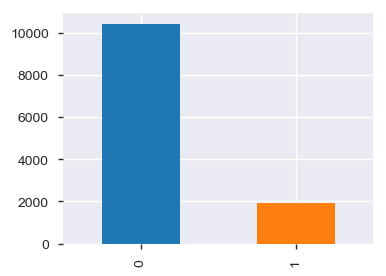

In [20]:
# ターゲットカラム集計
plt.figure(figsize=(4,3))
df["Revenue"].value_counts().plot.bar()
plt.show()

# 学習準備

In [21]:
# 準備
target_col = "Revenue"
delete_col = [target_col]
y = df[target_col]
X = df.drop(delete_col, axis=1)

In [22]:
#le = LabelEncoder()
#le.fit(y)
#y = le.transform(y)
#print(y)
#y = le.inverse_transform(y)
#print(y)

In [23]:
pd.get_dummies(y).head()

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [24]:
# e=1, p=0 と変換
# y = le.transform(y)

In [25]:
# One-Hot encoding
# ce_ohe = ce.one_hot.OneHotEncoder(drop_invariant=True, handle_unknown="ignore")
# X = ce_ohe.fit_transform(X)

In [26]:
# 訓練データと評価データを生成
X_train, X_test, y_train, y_test = train_test_split(X, y)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 学習

In [27]:
# Training APIを利用した書き方
# パラメータ設定
params = {
        'task': 'train',           # default = train
        'boosting_type': 'gbdt',   # default = gbft
        'objective': 'binary',     # default = regression
        'metric': {'binary_logloss'}, # default = None
        'learning_rate': 0.1,      # default = 0.1
        'num_leaves': 31,          # default = 31
        'min_data_in_leaf': 3,     # default = 20
        'num_iteration': 200,      # default = 100
        'verbose': -1,             # default = 1
        'seed': 40002,             # default = None
        'num_iterations': 100,     # default = 100
        'early_stopping_round':0,  # default = 0
}
# 学習
gbm = lgb.train(params,
    lgb_train,
    valid_sets=lgb_eval,
)

[1]	valid_0's binary_logloss: 0.370181
Training until validation scores don't improve for 0 rounds.
[2]	valid_0's binary_logloss: 0.343554
[3]	valid_0's binary_logloss: 0.323389
[4]	valid_0's binary_logloss: 0.307383
[5]	valid_0's binary_logloss: 0.29456
[6]	valid_0's binary_logloss: 0.284173
[7]	valid_0's binary_logloss: 0.274872
[8]	valid_0's binary_logloss: 0.267018
[9]	valid_0's binary_logloss: 0.260335
[10]	valid_0's binary_logloss: 0.254701
[11]	valid_0's binary_logloss: 0.249927
[12]	valid_0's binary_logloss: 0.245973
[13]	valid_0's binary_logloss: 0.241932
[14]	valid_0's binary_logloss: 0.238569
[15]	valid_0's binary_logloss: 0.235744
[16]	valid_0's binary_logloss: 0.233725
[17]	valid_0's binary_logloss: 0.231911
[18]	valid_0's binary_logloss: 0.229424
[19]	valid_0's binary_logloss: 0.227504
[20]	valid_0's binary_logloss: 0.226101
[21]	valid_0's binary_logloss: 0.225249
[22]	valid_0's binary_logloss: 0.223995
[23]	valid_0's binary_logloss: 0.222965
[24]	valid_0's binary_logloss

# 評価

In [28]:
# 予測
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_max = np.round(y_pred)

In [29]:
# 精度
accuracy_score(y_test, y_pred_max)

0.9049626986701265

In [30]:
# 評価レポート
target_names = ['p', 'e']
print(classification_report(y_test, y_pred_max, target_names=target_names))

              precision    recall  f1-score   support

           p       0.94      0.95      0.95      2641
           e       0.69      0.61      0.65       442

   micro avg       0.90      0.90      0.90      3083
   macro avg       0.81      0.78      0.80      3083
weighted avg       0.90      0.90      0.90      3083



In [31]:
# 変数重要度
importance = pd.DataFrame(gbm.feature_importance(), index=gbm.feature_name(), columns=['importance'])
display(importance)

,importance
Administrative,68
Administrative_Duration,124
Informational,22
Informational_Duration,38
ProductRelated,77
ProductRelated_Duration,116
BounceRates,80
ExitRates,163
PageValues,101
SpecialDay,8


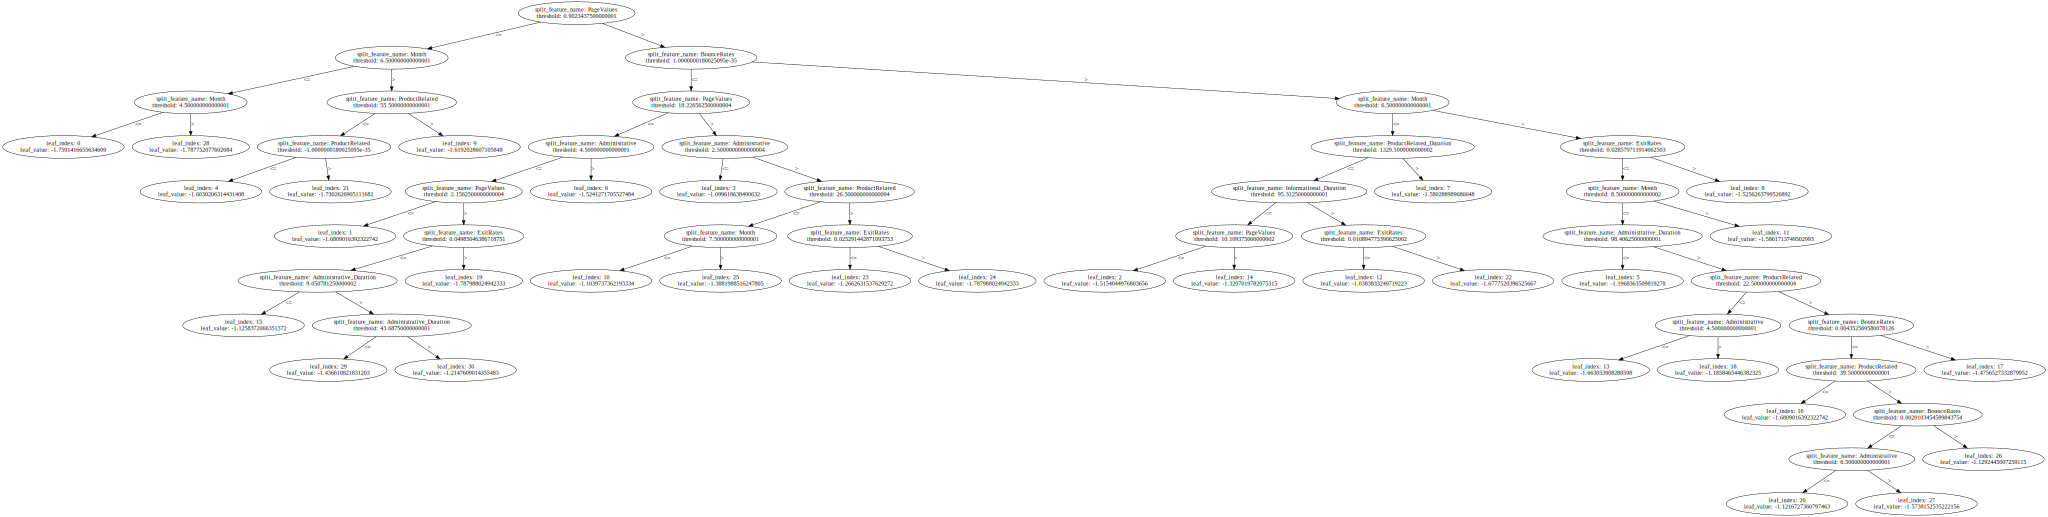

In [32]:
# 木の可視化 ... うまく描画するときとされないときがあるが ...
# lightgbm のいろいろな乱数シード依存な気がする
lgb.create_tree_digraph(gbm)
# graph.render(view=True)  # PDF に出力

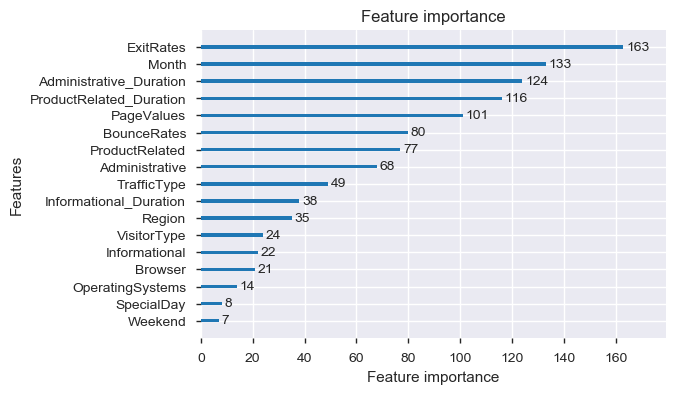

In [33]:
lgb.plot_importance(gbm, figsize=(6,4))
plt.show()

In [34]:
# scikit-learn API を利用
from sklearn.feature_selection import RFECV
gbm = lgb.LGBMClassifier(objective='binary',
                        num_leaves = 31,
                        learning_rate=0.1,
                        min_child_samples=10,
                        n_estimators=100)
selector = RFECV(gbm, step=1, cv=5)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True  True False  True  True  True  True  True  True False  True False
 False  True  True False False]
[1 1 3 1 1 1 1 1 1 7 1 6 2 1 1 4 5]


In [35]:
X_test.iloc[:, selector.support_].shape

(3083, 11)

In [36]:
# 予測
gbm.fit(X_train.iloc[:, selector.support_], y_train,
        eval_set=[(X_test.iloc[:, selector.support_], y_test)],
        eval_metric='binary_logloss',
        early_stopping_rounds=10)
y_pred_slapi = gbm.predict(X_test.iloc[:, selector.support_])

[1]	valid_0's binary_logloss: 0.370176	valid_0's binary_logloss: 0.370176
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.343205	valid_0's binary_logloss: 0.343205
[3]	valid_0's binary_logloss: 0.323207	valid_0's binary_logloss: 0.323207
[4]	valid_0's binary_logloss: 0.307217	valid_0's binary_logloss: 0.307217
[5]	valid_0's binary_logloss: 0.293921	valid_0's binary_logloss: 0.293921
[6]	valid_0's binary_logloss: 0.283306	valid_0's binary_logloss: 0.283306
[7]	valid_0's binary_logloss: 0.274204	valid_0's binary_logloss: 0.274204
[8]	valid_0's binary_logloss: 0.266871	valid_0's binary_logloss: 0.266871
[9]	valid_0's binary_logloss: 0.260699	valid_0's binary_logloss: 0.260699
[10]	valid_0's binary_logloss: 0.255392	valid_0's binary_logloss: 0.255392
[11]	valid_0's binary_logloss: 0.250523	valid_0's binary_logloss: 0.250523
[12]	valid_0's binary_logloss: 0.24653	valid_0's binary_logloss: 0.24653
[13]	valid_0's binary_logloss: 0.242918	valid_0's

In [37]:
# 評価レポート
target_names = ['p', 'e']
print(classification_report(y_test, y_pred_slapi, target_names=target_names))

              precision    recall  f1-score   support

           p       0.94      0.95      0.95      2641
           e       0.69      0.63      0.66       442

   micro avg       0.91      0.91      0.91      3083
   macro avg       0.81      0.79      0.80      3083
weighted avg       0.90      0.91      0.90      3083



In [38]:
# 原因不明のエラー。。
# from boruta import boruta_py
# gbm = lgb.LGBMClassifier(objective='binary',
#                         num_leaves = 31,
#                         learning_rate=0.1)
# feat_selector = boruta_py.BorutaPy(gbm, n_estimators='auto')
# feat_selector.fit(X_train.values, y_train.values)